## Data Science Final Project
By Daniel Zatakovi & Jeki Skif




### Project Name: Popular Albums Prediction

### Research Question: Is it possible to predict if an album will be popular using different features  


### Our data source: www.discogs.com 

In [2]:
import json
import bs4
from bs4 import BeautifulSoup  
import pandas as pd
import scipy as sc
import requests
from selenium import webdriver
import time
import re
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt      
import math
import seaborn as sns
from collections import Counter
from sklearn.decomposition import PCA
import sklearn
from sklearn import neighbors, tree, ensemble, naive_bayes, svm
from sklearn import linear_model, metrics, preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import r2_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import make_scorer
import string
%matplotlib inline

### Step 1: Data Acquisition
We decided to use Selenium in this project since it is a popular tool in the hi-tech industry and we wanted to
investigate it capabilities further in this course.

In [3]:
# load the webdriver, use options.headless to run it in the background
def load_webdriver():
    from selenium.webdriver.chrome.options import Options
    from selenium import webdriver
    Options = Options()
    Options.headless = True
    webdriver = webdriver.Chrome(options=Options)
    return webdriver

In [4]:
# Get urls of albums in a page
def extract_urls_data_per_page(webdriver):
    urls_block=webdriver.find_elements(By.CLASS_NAME, 'search_result_title')
    urls_list = []
    for url in urls_block:
        urls_list.append(url.get_attribute("href"))
    return urls_list


In [5]:
#using the previous function, we get the urls of all pages
def extract_url_list(): 
    url_template = 'https://www.discogs.com/search/?limit=250&sort=want%2Cdesc&ev=em_rs&decade=2010&page={}'
    all_albums_url = []
    page_num = 1
    webdriver = load_webdriver()
    while True:
        print("page num :" + str(page_num))
        url = url_template.format(page_num)
        webdriver.get(url)
        url_data = extract_urls_data_per_page(webdriver)
        if len(url_data) == 0:
            break
        if url_data is not None:
            all_albums_url.extend(url_data)
        page_num += 1
    return all_albums_url

In [6]:
# Feature num.1: Artist Name
def get_artist_name(webdriver):
    from selenium.common.exceptions import NoSuchElementException
    try:
        selenium_obj = webdriver.find_element(By.CLASS_NAME, 'title_1q3xW')
        selenium_obj = selenium_obj.find_element(By.CLASS_NAME, 'link_1ctor')
        artist_name = selenium_obj.get_attribute('innerHTML')
        return artist_name
    except NoSuchElementException:
        return None

In [7]:
# Feature num.2: Album Name
def get_album_name(webdriver):
    from selenium.common.exceptions import NoSuchElementException
    try:
        selenium_obj = webdriver.find_element(By.CLASS_NAME, 'title_1q3xW')
        obj_string = selenium_obj.get_attribute('innerHTML')
        album_name = obj_string.split('–')[1].strip().replace('<!--', '').replace('-->', '').strip()
        return album_name
    except NoSuchElementException:
        return None

In [8]:
# Feature num.3: Album Genre
def get_genre_name(webdriver):
    from selenium.common.exceptions import NoSuchElementException
    try:
        selenium_obj = webdriver.find_element(By.CLASS_NAME, 'table_1fWaB')
        selenium_obj = selenium_obj.find_element(By.CLASS_NAME, 'link_1ctor')
        genre_name = selenium_obj.get_attribute('innerHTML')
        return genre_name
    except NoSuchElementException:
        return None

In [9]:
# Feature num.4: Album Style
def get_style_name(webdriver):
    from selenium.common.exceptions import NoSuchElementException
    try:
        from selenium.common.exceptions import NoSuchElementException
        selenium_obj = webdriver.find_element(By.CLASS_NAME, 'table_1fWaB')
        selenium_obj = selenium_obj.find_elements(By.TAG_NAME,'td')
        style_name = selenium_obj[1].find_element(By.CLASS_NAME, 'link_1ctor')
        style_name = style_name.get_attribute('innerHTML')
        return style_name
    except NoSuchElementException:
        return None


In [10]:
# Feature num.5: Album Release Year
def get_album_year(webdriver):
    from selenium.common.exceptions import NoSuchElementException
    try:
        selenium_obj = webdriver.find_element(By.CLASS_NAME, 'table_1fWaB')
        selenium_obj = selenium_obj.find_elements(By.TAG_NAME,'td')
        album_year = selenium_obj[2].find_element(By.CLASS_NAME, 'link_1ctor')
        album_year = album_year.find_element(By.XPATH, "//time")
        album_year = album_year.get_attribute("innerHTML")
        return album_year
    except NoSuchElementException:
        return None
    

In [11]:
# Feature num.6: Album Tracklist Length
def get_album_tracklist_len(webdriver):
    from selenium.common.exceptions import NoSuchElementException
    try:
        selenium_obj = webdriver.find_element(By.CLASS_NAME,'tracklist_4KOvL')
        rows = selenium_obj.find_elements(By.TAG_NAME, "tr")
        rows_len = len(rows)
        return rows_len
    except NoSuchElementException:
        return None

In [12]:
# Feature num.7: Album Price
def get_album_price(webdriver):
    from selenium.common.exceptions import NoSuchElementException
    try:
        selenium_obj = webdriver.find_element(By.CLASS_NAME, 'price_2Wkos')
        price = selenium_obj.get_attribute("innerHTML")
        price = price.replace('$','')
        return price
    except NoSuchElementException:
        return None

In [13]:
# Feature num.8: How many people have this album
def get_album_haves(webdriver):
    from selenium.common.exceptions import NoSuchElementException
    try:
        selenium_object = webdriver.find_element(By.XPATH, '//div[@class="items_Y-X8L"][contains(.,"Have")]')    
        have_counter = selenium_object.find_element(By.CLASS_NAME, 'link_1ctor')
        have_counter = have_counter.get_attribute('innerHTML')
        return int(have_counter)
    except NoSuchElementException:
        return None

In [14]:
# Feature num.9: How many people want this album
def get_album_wants(webdriver):
    from selenium.common.exceptions import NoSuchElementException
    try:
        selenium_obj = webdriver.find_element(By.XPATH, '//div[@class="items_Y-X8L"][contains(.,"Have")]')    
        selenium_obj = selenium_obj.find_elements(By.TAG_NAME,'li')
        want_counter = selenium_obj[1].find_element(By.CLASS_NAME,'link_1ctor')
        want_counter = want_counter.get_attribute('innerHTML')
        return int(want_counter)
    except NoSuchElementException:
        return None

In [15]:
# Our research label: The rating of the album
def get_album_rating_avg(webdriver):
    from selenium.common.exceptions import NoSuchElementException
    try:
        x = webdriver.find_element(By.XPATH, '//div[@class="items_Y-X8L"][contains(.,"Avg Rating")]')
        y = x.find_elements(By.TAG_NAME,'li')
        z = y[0].find_elements(By.TAG_NAME,'span')
        avg_rating = z[1].get_attribute('innerHTML').split("<!")[0]
        if(avg_rating == '--'):
            return None
        return float(avg_rating)
    except NoSuchElementException:
        return None

In [16]:
# Feature num.10: How many people rated this album
def get_album_total_ratings(webdriver):    
    from selenium.common.exceptions import NoSuchElementException
    try:
        x = webdriver.find_element(By.XPATH, '//div[@class="items_Y-X8L"][contains(.,"Avg Rating")]')
        y = x.find_elements(By.CLASS_NAME,'link_1ctor')
        num_rating = y[0].get_attribute('innerHTML')
        if(num_rating == '--'):
            return None
        return int(num_rating)
    except NoSuchElementException:
        return None

In [16]:
# Data consolidation before making it as a dataframe 
def extract_data_from_album_url(all_albums_url):
    webdriver = load_webdriver()
    artists_name_list=[]
    albums_name_list = []
    genres_name_list =[]
    style_name_list = []
    album_year_list = []
    album_tracklist_len_list = []
    album_price_list = []
    album_have_count_list = []
    album_want_count_list = []
    avg_rating_list = []
    total_rating_list = []
    for url in all_albums_url:
        print(url)
        webdriver.get(url)
        artists_name_list.append(get_artist_name(webdriver))
        albums_name_list.append(get_album_name(webdriver))
        genres_name_list.append(get_genre_name(webdriver))
        style_name_list.append(get_style_name(webdriver))
        album_year_list.append(get_album_year(webdriver))
        album_tracklist_len_list.append(get_album_tracklist_len(webdriver))
        album_price_list.append(get_album_price(webdriver))
        album_have_count_list.append(get_album_haves(webdriver))
        album_want_count_list.append(get_album_wants(webdriver))
        avg_rating_list.append(get_album_rating_avg(webdriver))
        total_rating_list.append(get_album_total_ratings(webdriver))
        time.sleep(2)
    return artists_name_list,albums_name_list,genres_name_list, style_name_list, album_year_list, album_tracklist_len_list, album_price_list, album_have_count_list, album_want_count_list, avg_rating_list,total_rating_list

In [18]:
# Creating a csv file and saving it for usage during the project.
def create_CSV():
    df_list = extract_data_from_album_url(extract_url_list())
    df = pd.DataFrame({'Artist Name' : df_list[0],
                      'Album Name' : df_list[1],
                      'Genre' : df_list[2],
                      'Style': df_list[3],
                       'Year': df_list[4],
                       'Tracklist Length': df_list[5],
                       'Price (USD)': df_list[6],
                       'Have Counter': df_list[7],
                       'Want Counter': df_list[8],
                      'Rating' : df_list[9],
                      'Amount Of Ratings' : df_list[10]})
    df.to_csv("all_data.csv")
    print(df)

In [19]:
create_CSV()

In [3]:
# Making a dataframe from the csv
df = pd.read_csv("all_data.csv", index_col=False)

In [4]:
df

,Unnamed: 0,Artist Name,Album Name,Genre,Style,Year,Tracklist Length,Price (USD),Have Counter,Want Counter,Rating,Amount Of Ratings
0,0,Daft Punk,Random Access Memories,Electronic,Disco,2013,13.0,2.17,115236.0,58647.0,4.54,12374.0
1,1,Frank Ocean,Blond,Hip Hop,Contemporary R&B,2016,17.0,22.14,31714.0,58258.0,4.70,2571.0
2,2,King Gizzard And The Lizard Wizard,Polygondwanaland,Rock,Psychedelic Rock,2017,10.0,5.98,25898.0,42831.0,4.63,2432.0
3,3,Tame Impala,Currents,Rock,Indie Rock,2015,13.0,1.09,73452.0,43060.0,4.53,5534.0
4,4,Kanye West,My Beautiful Dark Twisted Fantasy,Hip Hop,Contemporary R&B,2010,13.0,1.65,58808.0,39114.0,4.18,4921.0
...,...,...,...,...,...,...,...,...,...,...,...,...
9977,9977,Gorillaz,Humanz,Parlophone,Box Set,03-Nov-17,NaN,163.03,NaN,NaN,NaN,NaN
9978,9978,Mayhem,De Mysteriis Dom Sathanas,Back On Black,Vinyl,2010,NaN,26.05,NaN,NaN,NaN,NaN
9979,9979,Ratatat,LP4,XL Recordings,Vinyl,08-Jun-10,NaN,35.00,NaN,NaN,NaN,NaN
9980,9980,Brenda Ray,Walatta,EM Records,Vinyl,2012,NaN,NaN,NaN,NaN,NaN,NaN


### Step 2: Data cleansing

We will delete unrelevant fields in our dataframe such as duplicates, N/A, and optimise our data for the research

In [5]:
df.drop('Unnamed: 0',axis = 1, inplace = True)

In [6]:
# Delete the N/A fields and duplicates
df.dropna(inplace = True)
df.drop_duplicates(inplace = True)

In [7]:
# We do not want albums that are longer than 20 tracks since they are a minority and they will adversely affect the research
df = df[df['Tracklist Length'] <= 20]

In [8]:
# The album name and artist are not relevant for our machine learning since they are unique for a specific albums
df.drop('Artist Name',axis = 1, inplace = True)
df.drop('Album Name',axis = 1, inplace = True)

C:\Users\jjeki\AppData\Local\Temp\ipykernel_28324\3416148948.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('Artist Name',axis = 1, inplace = True)
C:\Users\jjeki\AppData\Local\Temp\ipykernel_28324\3416148948.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('Album Name',axis = 1, inplace = True)


In [9]:
# In our early analysis of our data, we saw that the 'Style' is similar to 'Genre' so we won't use it
df.drop('Style',axis = 1, inplace = True)

C:\Users\jjeki\AppData\Local\Temp\ipykernel_28324\2689670471.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('Style',axis = 1, inplace = True)


In [10]:
df.reset_index(drop = True , inplace = True)

In [11]:
# Change strings to numbers
df['Price (USD)'] = df['Price (USD)'].astype(float)
df['Year'] = df['Year'].astype(int)

C:\Users\jjeki\AppData\Local\Temp\ipykernel_28324\1760735445.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Price (USD)'] = df['Price (USD)'].astype(float)
C:\Users\jjeki\AppData\Local\Temp\ipykernel_28324\1760735445.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = df['Year'].astype(int)


In [12]:
# We do not want albums that are very expensive and have little to no 'Have' , 'Want', 'Number of Ratings' counter,
# since they are a minority and they will adversely affect the research
filtered_df = df[(df['Price (USD)'] <= 200) &
                 (df['Have Counter'].between(1000, 35000)) &
                 (df['Want Counter'].between(1000, 35000)) &
                 (df['Amount Of Ratings'] >= 100)]
df_clean = pd.DataFrame(filtered_df)

### Step 3: Data visualization


In [13]:
# We decided to use the 7 genres with the largest amount of albums for this project
def get_freq_elements(df_clean, col_name, num):
    freq_elements = df_clean[col_name].value_counts()[:num]
    series = pd.Series(freq_elements).sort_index(ascending=True)
    return series

In [14]:
genres_freq = get_freq_elements(df_clean,'Genre',7)

In [15]:
genres_freq

Electronic                1175
Folk, World, & Country      44
Funk / Soul                 84
Hip Hop                    185
Jazz                        69
Pop                         36
Rock                      1648
Name: Genre, dtype: int64

<AxesSubplot:>

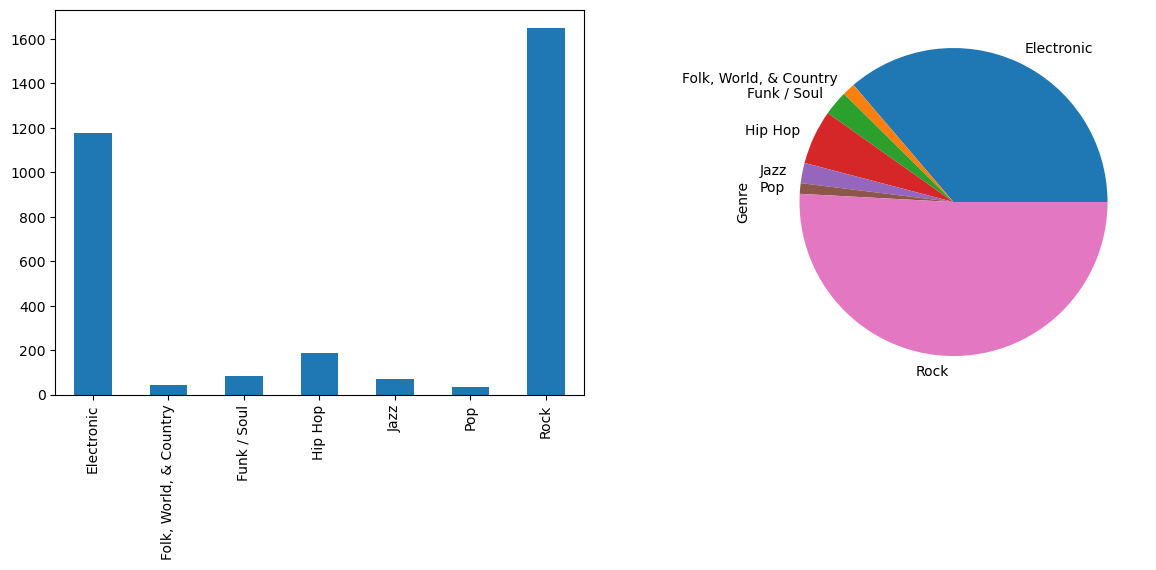

In [16]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
genres_freq.plot(kind = 'pie', ax = axes[1])
genres_freq.plot(kind = 'bar', ax = axes[0])

In [17]:
# We made a new dataframe that consists of the 7 genres with the most albums
genre_list=[]
df_freq_genre = df_clean.copy()
genres_freq = get_freq_elements(df,'Genre',7)
for key in genres_freq.keys():
    genre_list.append(key)   
df_freq_genre= df_freq_genre[df_freq_genre['Genre'].isin(genre_list)]
df_freq_genre =df_freq_genre.reset_index()          
del df_freq_genre["index"]

In [18]:
# Since our project revolves around whether an album is popular, we changed the rating value to 0 and 1 labeling
df_freq_genre['Rating'] = [1 if rating >= 4.5 else 0 for rating in df_freq_genre['Rating']]

In [19]:
# We want to see how many populars albums there are in each genre, year and tracklist length
ct_genre = pd.crosstab(df_freq_genre['Genre'],df_freq_genre['Rating'],normalize='index')
ct_year = pd.crosstab(df_freq_genre['Year'],df_freq_genre['Rating'],normalize='index')
ct_tracklist_length = pd.crosstab(df_freq_genre['Tracklist Length'],df_freq_genre['Rating'],normalize='index')
display(ct_genre)
display(ct_year)
display(ct_tracklist_length)

Rating,0,1
Genre,,
Electronic,0.511489,0.488511
"Folk, World, & Country",0.477273,0.522727
Funk / Soul,0.428571,0.571429
Hip Hop,0.718919,0.281081
Jazz,0.347826,0.652174
Pop,0.611111,0.388889
Rock,0.697209,0.302791


Rating,0,1
Year,,
2010,0.713855,0.286145
2011,0.675676,0.324324
2012,0.680115,0.319885
2013,0.711735,0.288265
2014,0.615854,0.384146
2015,0.632479,0.367521
2016,0.578431,0.421569
2017,0.501558,0.498442
2018,0.432727,0.567273


Rating,0,1
Tracklist Length,,
1.0,0.250000,0.750000
2.0,0.392308,0.607692
3.0,0.217391,0.782609
4.0,0.310345,0.689655
5.0,0.377049,0.622951
6.0,0.404494,0.595506
7.0,0.426966,0.573034
8.0,0.496894,0.503106
9.0,0.568282,0.431718


Text(0, 0.5, 'Relative Frequency')

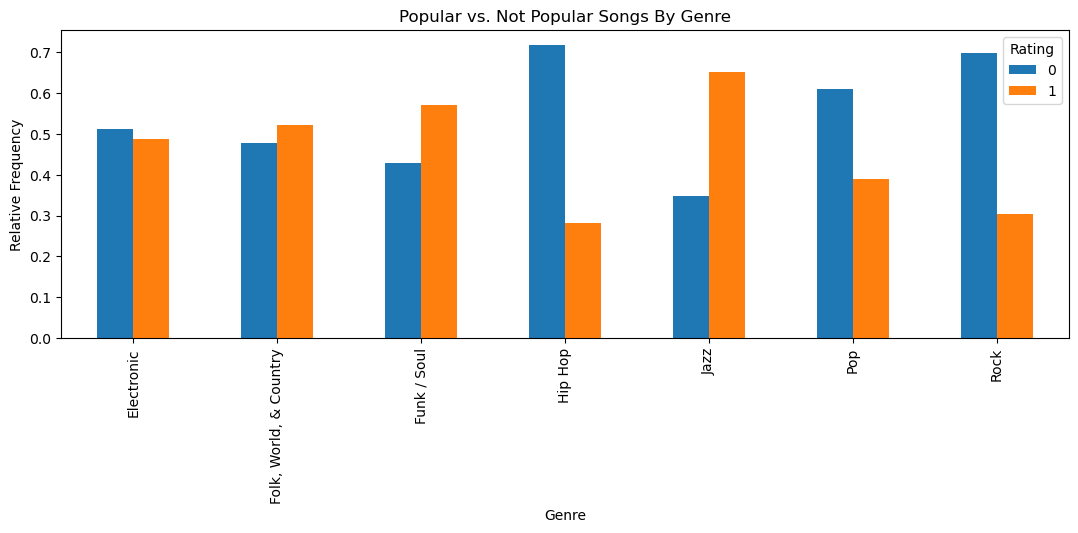

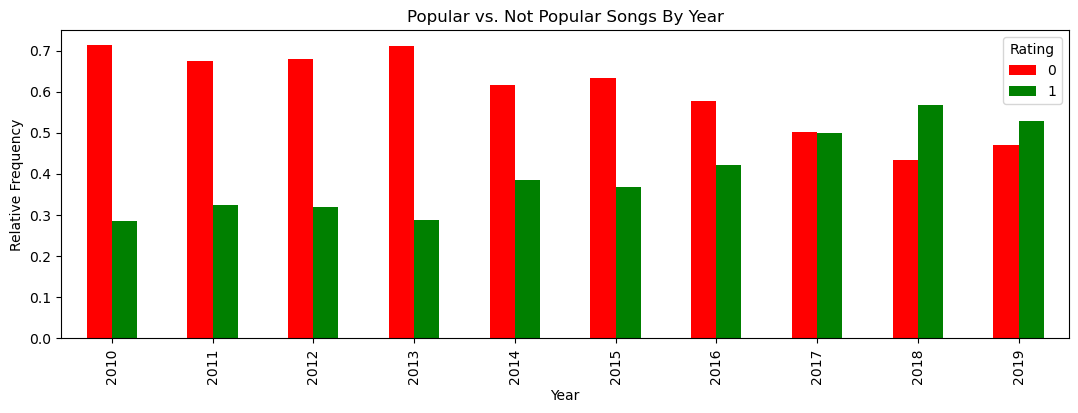

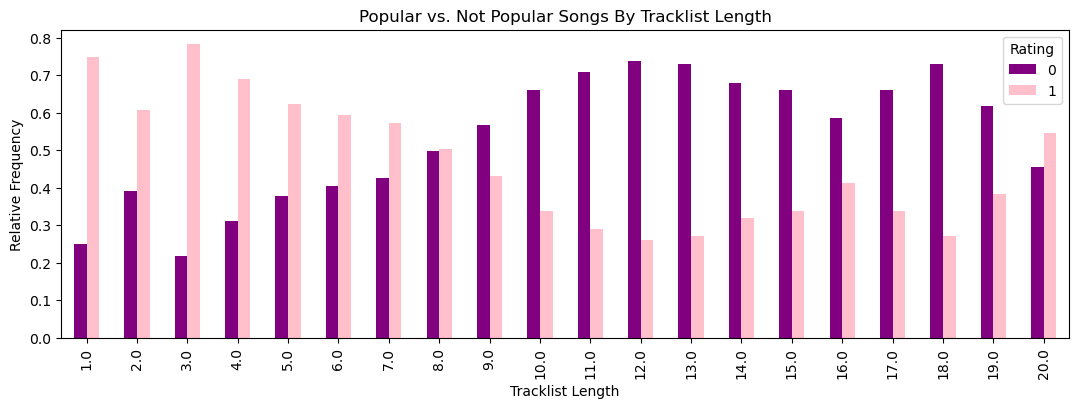

In [20]:
ct_genre.plot(kind = 'bar' , figsize = (13,4))
plt.title("Popular vs. Not Popular Songs By Genre")
plt.xlabel('Genre')
plt.ylabel('Relative Frequency')

colors = ['red', 'green']
ct_year.plot(kind = 'bar' , figsize = (13,4), color = colors)
plt.title("Popular vs. Not Popular Songs By Year")
plt.xlabel('Year')
plt.ylabel('Relative Frequency')

colors = ['purple', 'pink']
ct_tracklist_length.plot(kind = 'bar' , figsize = (13,4), color = colors)
plt.title("Popular vs. Not Popular Songs By Tracklist Length")
plt.xlabel('Tracklist Length')
plt.ylabel('Relative Frequency')

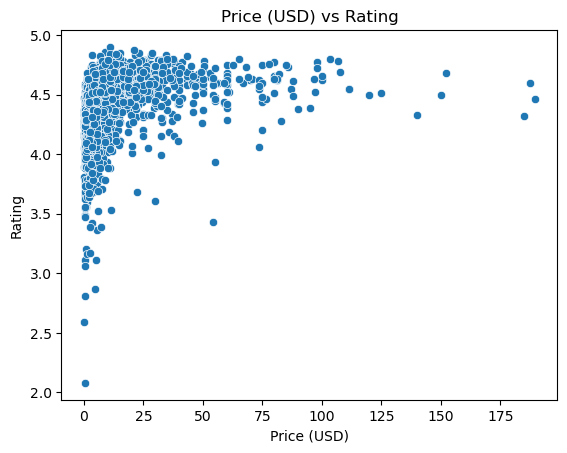

In [21]:
# We wanted to see if there is a connection between an album price and it's popularity
sns.scatterplot(data=df_clean, x='Price (USD)', y='Rating')
plt.xlabel('Price (USD)')
plt.ylabel('Rating')
plt.title('Price (USD) vs Rating')
plt.show()

plt.figure(figsize = (13,4))
sns.boxplot(df_freq_genre.Genre,df_freq_genre.Year)

### Step 4: Machine learning

In [22]:
def genre_to_numeric_values(dataset):
    df_factorize = dataset.copy()
    df_factorize.dropna(inplace=True)
    df_factorize.drop_duplicates(inplace=True)
    df_factorize['Genre'] = pd.factorize(df_factorize['Genre'])[0]
    return df_factorize

In [23]:
df_ml = genre_to_numeric_values(df_clean)

In [24]:
def split_to_train_and_test(dataset, label_column, test_ratio, rand_state):
    #split
    X = dataset.drop(columns=label_column)
    y = dataset[label_column]
    
    #train
    X_train , X_test = train_test_split(X,train_size=1-test_ratio ,random_state=rand_state)
    Y_train , Y_test = train_test_split(y, train_size= 1-test_ratio ,random_state=rand_state)
    return X_train, X_test, Y_train, Y_test

In [25]:
test_ratio, rand_state = 0.3, 7
category_col_name = 'Rating'
dataset = genre_to_numeric_values(df_freq_genre) 
X_train, X_test, y_train, y_test = split_to_train_and_test(dataset, category_col_name, test_ratio, rand_state)

In [26]:
def get_classifier(classifier_name, params):
     
    if classifier_name == 'naive_bayes':
        return GaussianNB()
            
    if classifier_name == 'svm':
        return SVC()
    
    if classifier_name == 'decision_tree':
        if params == None:
            return tree.DecisionTreeClassifier()
        else:
            return tree.DecisionTreeClassifier(max_depth=params["max_depth"] ,
                                          min_samples_split=params["min_samples_split"])
    
    if classifier_name == 'random_forest':
        if params == None:
            return RandomForestClassifier()
        else:
            return RandomForestClassifier(n_estimators = params['n_estimators'])

    if classifier_name == 'KNN':
        if params == None:
            clf = KNeighborsClassifier()
            return clf
        else:
            clf = KNeighborsClassifier(n_neighbors=params['n_neighbors'])
            return clf

In [27]:
def calc_evaluation_val(eval_metric, y_test, y_predicted):
  
    if eval_metric == "accuracy":
        return metrics.accuracy_score(y_test, y_predicted)
    
    elif eval_metric == "precision":
        return metrics.precision_score(y_test, y_predicted)
    
    elif eval_metric == "recall":
        return metrics.recall_score(y_test, y_predicted,average='micro')
    
    elif eval_metric == "f1":
        return metrics.f1_score(y_test, y_predicted)
    
    else : #confusion_matrix
        return confusion_matrix(y_test, y_predicted)
    

In [28]:
def find_best_decision_tree_params(X_train, y_train):
    parameters = {'max_depth':[2,4,6],"min_samples_split":[7,14,28]}
    dtree = tree.DecisionTreeClassifier()
    clf = GridSearchCV(dtree, parameters, scoring=make_scorer(metrics.f1_score, greater_is_better=True))
    clf.fit(X_train, y_train)
    best_max_depth = clf.best_params_['max_depth']
    best_min_samples_split = clf.best_params_["min_samples_split"]
    best_f1_val = clf.best_score_
    return best_max_depth, best_min_samples_split, best_f1_val

In [29]:
X_train, X_test, y_train, y_test = split_to_train_and_test(dataset, category_col_name, test_ratio, rand_state)
best_max_dep, best_min_smpl_splt, best_f1_DT_params = find_best_decision_tree_params(X_train, y_train)

In [30]:
def find_best_random_forest_num_estimators(X_train, y_train):
    parameters = {'n_estimators':[11,51,71]}
    rf = RandomForestClassifier()
    clf = GridSearchCV(rf, parameters, scoring=make_scorer(metrics.f1_score, greater_is_better=True))
    clf.fit(X_train, y_train)
    best_num_estimators = clf.best_params_['n_estimators']
    best_f1_val = clf.best_score_
    return best_num_estimators, best_f1_val

In [31]:
X_train, X_test, y_train, y_test = split_to_train_and_test(dataset, category_col_name, test_ratio, rand_state)
best_n_estimators, best_f1_RF_params = find_best_random_forest_num_estimators(X_train, y_train)

In [32]:
def find_best_k_for_KNN(X_train, y_train):
    ###
    knn = KNeighborsClassifier()
    parameters = {'n_neighbors':[3,7,9,11] }
    clf = GridSearchCV(knn, parameters,scoring=make_scorer(metrics.f1_score, greater_is_better=True))
    clf.fit(X_train, y_train)
    return clf.best_params_['n_neighbors'] , clf.best_score_

In [33]:
test_ratio, rand_state = 0.5, 42
category_col_name = 'Rating'
X_train, X_test, y_train, y_test = split_to_train_and_test(dataset, category_col_name, test_ratio, rand_state)
best_K, best_f1_KNN_params = find_best_k_for_KNN(X_train, y_train)

C:\Users\jjeki\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\jjeki\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

In [34]:
def find_best_model(X_train, y_train, max_depth_val, min_samples_split_val):
    parameters = {'max_depth':max_depth_val,"min_samples_split":min_samples_split_val}
    best_clf = None
    best_recall_val = -1
    algos = ["svm","naive_bayes","decision_tree"]
    
    for alg in algos:
        clf = get_classifier(alg,parameters)
        clf.fit(X_train, y_train)
        y_pred_train = clf.predict(X_train)
        recall = calc_evaluation_val('recall',y_train,y_pred_train)
        print(clf, recall)
        if recall > best_recall_val:
            best_recall_val = recall
            best_clf = clf
    
    return best_clf, best_recall_val

In [38]:
test_ratio, rand_state = 0.2, 42
category_col_name = 'Rating'
max_dep=4
min_smpl_splt=20
dataset
X_train, X_test, y_train, y_test = split_to_train_and_test(dataset, category_col_name, test_ratio, rand_state)
best_clf, best_recall_val=find_best_model(X_train, y_train, max_dep, min_smpl_splt)
print("KNN Accuracy: " , best_f1_KNN_params )
print("random forest Accuracy: " , best_f1_RF_params )

SVC() 0.6986882716049383
GaussianNB() 0.7195216049382716
DecisionTreeClassifier(max_depth=4, min_samples_split=20) 0.7554012345679012
KNN Accuracy:  0.5338015873015873
random forest Accuracy:  0.6813779082883306


In [36]:
print(best_clf, best_recall_val)

DecisionTreeClassifier(max_depth=4, min_samples_split=10) 0.7554012345679012
